# Práctica 6 - RANSAC


In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from imageio import imread
%matplotlib inline
from functools import reduce

In [2]:
def printVars(results):
    for key in results.keys():
        print(key)
        print(results[key])
        print(" ")

In [3]:
def printList(l):
    i = 0
    for elem in l:
        print(elem)
        if (i%2 == 1):
            print(" ")
        i += 1

In [4]:
def aplicarHsobrePunto(Hparam, x,y,z=1):
    punto = np.array([x,y,z])
    punto = Hparam @ punto # aplicamos H
    punto = punto/punto[2] # normalizamos
    return (int(punto[0]),int(punto[1]))

In [5]:
def aplicarH(H, img):
    imgTransformada = np.zeros(img.shape)

    for i in range(img.shape[1]):
        for j in range(img.shape[0]):
            punto = np.array([i,j,1])
            punto = H @ punto
            punto = punto/punto[2]
            puntoX = int(punto[0])
            puntoY = int(punto[1])

            
            if (puntoY < img.shape[0] and  puntoY>= 0) and (puntoX< img.shape[1] and puntoX>= 0):
                imgTransformada[j, i, :] = img[puntoY,puntoX,:].astype(np.uint8)


    return imgTransformada

In [6]:
def invertirCoordenadas(conjuntoPuntos):
    return [(p[1],p[0]) for p in conjuntoPuntos]

In [7]:
cuatroPuntosDamero = [(289,259),(685,266),(282,1036),(665,1045)]
cuatroPuntosOtroDamero = [(188,246),(593,126),(402,1069),(833,961)]

puntosDamero = [(289,259),(388,261),(487,262),(586,264),(685,266), \
                (288,359),(387,361),(485,363),(583,365),(682,366), \
                (288,458),(365,461),(483,463),(581,465),(680,466), \
                (287,557),(385,559),(482,562),(579,563),(677,565), \
                (286,654),(383,656),(480,658),(577,660),(674,662), \
                (285,750),(382,752),(478,754),(575,755),(672,758), \
                (284,846),(381,848),(477,849),(573,852),(670,854), \
                (283,942),(379,943),(475,946),(571,948),(668,951), \
                (282,1036),(377,1039),(473,1040),(569,1043),(665,1045), \
                (281,1129),(377,1131),(471,1134),(568,1136),(662,1138)]


puntosOtroDamero = [(188,246),(288,216),(388,186),(491,156),(593,126), \
                (214,344),(314,314),(416,284),(518,254),(622,224), \
                (240,444),(341,414),(443,385),(547,356),(651,325), \
                (267,544),(369,516),(471,487),(575,458),(680,428), \
                (293,647),(396,618),(499,590),(603,561),(709,532), \
                (320,749),(423,721),(527,693),(633,665),(740,637), \
                (347,854),(451,826),(556,798),(663,771),(770,742), \
                (375,961),(480,933),(586,906),(693,879),(802,852), \
                (402,1069),(509,1043),(615,1015),(724,989),(833,961), \
                (430,1178),(538,1152),(644,1125),(754,1098),(862,1072)]

###### Redefinicion de puntos intercambiando coordenadas
puntosDamero = invertirCoordenadas(puntosDamero)
puntosOtroDamero = invertirCoordenadas(puntosOtroDamero)

cuatroPuntosDamero = invertirCoordenadas(cuatroPuntosDamero)
cuatroPuntosOtroDamero = invertirCoordenadas(cuatroPuntosOtroDamero)


In [8]:
def marcar(pl, x, y):
    pl.plot(y,x,'bo', markersize=10)


In [9]:
def sumarMatriz(m1,m2): # a m1 le suma m2
    for i in range(len(m1)):
        for j in range(len(m1[0])):
            m1[i][j] = m1[i][j] + m2[i][j]        

In [10]:
def aplicarHsobrePuntoP2(H,p):
    vect = np.array([p[0],p[1],p[2]])
    res = H@vect
    x_pr = int(res[0])
    y_pr = int(res[1])
    z_pr = int(res[2])
    return(x_pr,y_pr,z_pr)

In [11]:
def dlt(puntos, otrosPuntos):
    puntosX = [p[0] for p in puntos]
    puntosY = [p[1] for p in puntos]
    
    otrosPuntosX = [p[0] for p in otrosPuntos]
    otrosPuntosY = [p[1] for p in otrosPuntos]
    
    ###
    "Buscamos el promedio y el desvío standard de ambos conjuntos de puntos de correspondencias"
    "Luego los normalizamos. O sea, les restamos el promedio y multiplicamos por sqrt(2)/desvio. \
    Esto es equivalente a armar la H que transforma al espacio normal. esta H es de 3x3, que escala y traslada. \
    H = [[s 0 -Mediax.s] [0 s -Mediay.s] [0 0 1]] obs: va a haber una H por conjunto de puntos. \
    A la primera H la llamamos H moño, a la segunda H moño prima."
    puntosPromedio = np.mean(puntos, axis=0)
    otrosPuntosPromedio = np.mean(otrosPuntos, axis=0)
    puntosCentrados = puntos - np.tile(puntosPromedio, (len(puntos),1))
    otrosPuntosCentrados = otrosPuntos - np.tile(otrosPuntosPromedio, (len(puntos),1))
    normaPuntos = np.linalg.norm(puntosCentrados, axis=1)
    normaOtrosPuntos = np.linalg.norm(otrosPuntosCentrados, axis=1)
    dPuntos = np.mean(normaPuntos)
    dOtrosPuntos = np.mean(normaPuntos)

    sPuntos = np.sqrt(2)/dPuntos
    sOtrosPuntos = np.sqrt(2)/dOtrosPuntos

    Hnorm = np.array([[sPuntos,0      ,-np.mean(puntosX)*sPuntos],
                      [0      ,sPuntos,-np.mean(puntosY)*sPuntos],
                      [0      ,0      ,1]])

    HnormPrima = np.array([[sOtrosPuntos,0      ,-np.mean(otrosPuntosX)*sOtrosPuntos],
                          [0      ,sOtrosPuntos,-np.mean(otrosPuntosY)*sOtrosPuntos],
                          [0      ,0      ,1]])
    
    ###
    "Pasamos los puntos a P2"
    puntosP2 = [(p[1],p[0],1)for p in zip(puntosX, puntosY)]
    otrosPuntosP2 = [(p[1],p[0],1)for p in zip(otrosPuntosX, otrosPuntosY)]
    
    ###
    "Armamos las Ai, con eso armamos la A, y con eso obtenemos V. \
    Con V obtenemos la H con puntito arriba, y con eso obtenemos la H final"
    A = []
    puntosP2Homologos = [Hnorm @ np.transpose(p) for p in puntosP2]
    otrosPuntosP2Homologos = [(HnormPrima @ np.transpose(p)) for p in otrosPuntosP2]

    for (x, xPrima) in zip(puntosP2Homologos, otrosPuntosP2Homologos):
        A.append([0,0,0,  -xPrima[2]*x[0], -xPrima[2]*x[1], -xPrima[2]*x[2],    xPrima[1]*x[0], xPrima[1]*x[1], xPrima[1]*x[2]])
        A.append([xPrima[2]*x[0], xPrima[2]*x[1], xPrima[2]*x[2],   0,0,0,  -xPrima[0]*x[0], -xPrima[0]*x[1], -xPrima[0]*x[2]])
        
    ###
    u,d,vt = np.linalg.svd(A)
    "Con esta descomposición tenemos que la última columna de la matriz V corresponde al vector de menor valor singular de la matriz A. O sea que la última fila de V corresponde al vector de menor valor singular de A"
    "ultima columna de la matriz V = ultima fila de la matriz Vt"
    fila = vt[-1]

    Hpuntito = [[fila[0],fila[1],fila[2]],[fila[3],fila[4],fila[5]],[fila[6],fila[7],fila[8]]]
    
    ###
    "Hpuntito corresponde a la H con puntito arriba descripta en las diapositivas. \
    Para obtener la H final debemos considerar la normalización que calculamos previamente"
    HnormPrimaInv = np.linalg.inv(HnormPrima)
    Hfinal = np.dot(HnormPrimaInv, np.dot(Hpuntito, Hnorm))
    Hfinal = Hfinal/Hfinal[2,2]

    return np.linalg.inv(Hfinal)

# RANSAC vs DLT sin RANSAC

## Mezclamos los puntos de correspondencia originales con ruido aleatorio fabricado por nosotros. Proporción de ruido = 30%

In [12]:
d1 = imread("img/dameros/damero1.png");
d2 = imread("img/dameros/damero2.png");

In [35]:
cantRuido = 15   # cantidad de correspondencias ruidosas agregadas
cantCorresp = 35    # cantidad de correspondencias correctas (maximo 50)

indicesPuntosDamero = np.random.choice(50, size = cantCorresp, replace = False)

# ruido puramente aleatorio, agrega correspondencias completamente random
nuevoPuntosDameroConRuido = [puntosDamero[i] for i in indicesPuntosDamero] + [(random.randint(259,1129),random.randint(289,662)) for j in range(cantRuido)]
nuevoPuntosOtroDameroConRuido = [puntosOtroDamero[i] for i in indicesPuntosDamero] +  [(random.randint(259,1129),random.randint(289,662)) for j in range(cantRuido)]

puntosDameroConRuido = [(1129, 281), (750, 285), (854, 670), (656, 383), (366, 682), (660, 577), (1136, 568), (1138, 662), (264, 586), (846, 284), (365, 583), (946, 475), (463, 483), (458, 288), (466, 680), (1131, 377), (942, 283), (559, 385), (461, 365), (359, 288), (658, 480), (758, 672), (662, 674), (943, 379), (363, 485), (465, 581), (266, 685), (1045, 665), (1039, 377), (754, 478), (848, 381), (565, 677), (755, 575), (262, 487), (259, 289), (316, 364), (496, 315), (463, 512), (534, 413), (1044, 648), (1024, 369), (715, 417), (718, 633), (945, 575), (986, 622), (1077, 400), (341, 292), (1077, 659), (623, 632), (529, 377)]
puntosOtroDameroConRuido = [(1178, 430), (749, 320), (742, 770), (618, 396), (224, 622), (561, 603), (1098, 754), (1072, 862), (156, 491), (854, 347), (254, 518), (906, 586), (385, 443), (444, 240), (325, 651), (1152, 538), (961, 375), (516, 369), (414, 341), (344, 214), (590, 499), (637, 740), (532, 709), (933, 480), (284, 416), (356, 547), (126, 593), (961, 833), (1043, 509), (693, 527), (826, 451), (428, 680), (665, 633), (186, 388), (246, 188), (759, 321), (1042, 373), (1080, 463), (259, 446), (288, 353), (303, 492), (507, 590), (282, 653), (735, 493), (486, 647), (569, 327), (769, 336), (897, 572), (998, 373), (439, 460)]




#puntosDameroConRuido = cuatroPuntosDamero + [(random.randint(259,1129),random.randint(289,662)) for j in range(4)]
#puntosOtroDameroConRuido = cuatroPuntosOtroDamero + [(random.randint(259,1129),random.randint(289,662)) for j in range(4)]


########################################################################################################################


# ruido mas amable, corre algunas correspondencias existentes un poco
#puntosDameroConRuido = [puntosDamero[i] for i in indicesPuntosDamero] + \
#    [(random.randint(-50,50)+puntosDamero[i][0], random.randint(-50,50)+puntosDamero[i][1]) for i in indicesPuntosDamero]
#puntosOtroDameroConRuido = [puntosOtroDamero[i] for i in indicesPuntosDamero] +  \
#    [(random.randint(-50,50)+puntosOtroDamero[i][0], random.randint(-50,50)+puntosOtroDamero[i][1]) for i in indicesPuntosDamero]
    
# ruido mas amable, corre todas las correspondencias existentes un poco
#puntosDameroConRuido = [(random.randint(-50,50)+puntosDamero[i][0], random.randint(-50,50)+puntosDamero[i][1]) \
                                                                                    #for i in indicesPuntosDamero]
#puntosOtroDameroConRuido =  [(random.randint(-50,50)+puntosOtroDamero[i][0], \
#                              random.randint(-50,50)+puntosOtroDamero[i][1]) \
#                                                 for i in indicesPuntosDamero]


### Podemos observar en ambas figuras, que los puntos en las esquinas son correspondencias correctas, y los puntos fuera de las esquinas son el ruido agregado

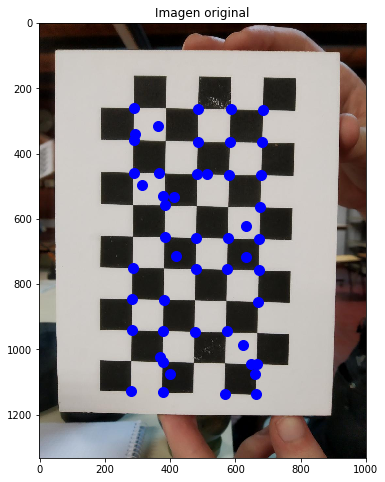

In [38]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Imagen original")
plt.imshow(d1)

for elem in puntosDameroConRuido:
    marcar(plt, elem[0], elem[1])

plt.show()

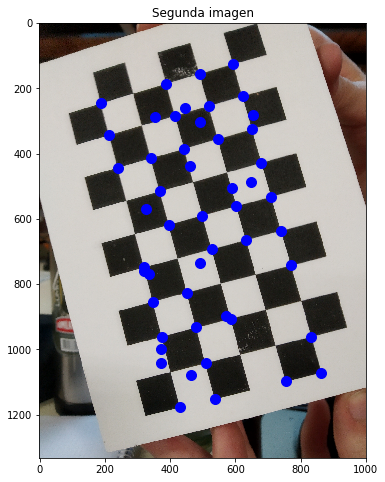

In [39]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Segunda imagen")
plt.imshow(d2)

for elem in puntosOtroDameroConRuido:
    marcar(plt, elem[0], elem[1])

plt.show()

# Resultado de DLT sin aplicar RANSAC

In [40]:
dResultado = aplicarH(dlt(puntosDameroConRuido,puntosOtroDameroConRuido), d1)


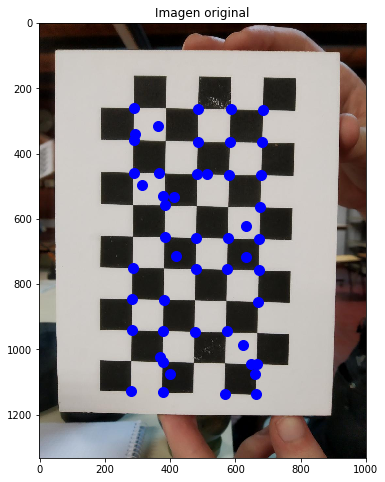

In [41]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Imagen original")
plt.imshow(d1.astype(np.uint8));

for elem in puntosDameroConRuido:
    marcar(plt, elem[0], elem[1])

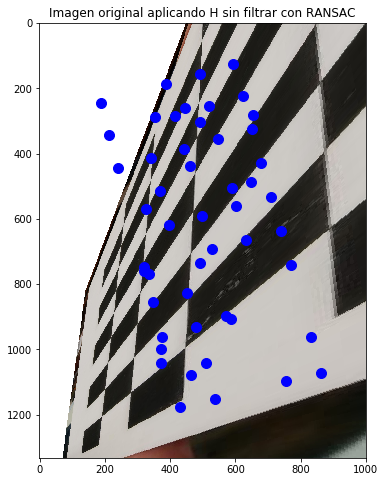

In [42]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Imagen original aplicando H sin filtrar con RANSAC")
plt.imshow(dResultado.astype(np.uint8));

for elem in puntosOtroDameroConRuido:
    marcar(plt, elem[0], elem[1])

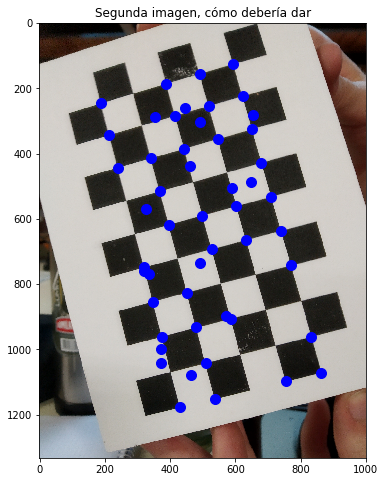

In [43]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Segunda imagen, cómo debería dar")
plt.imshow(d2);

for elem in puntosOtroDameroConRuido:
    marcar(plt, elem[0], elem[1])

## ¿Qué ocurrió?

El porcentaje de ruido fue demasiado para calcular la homografía sin filtrar las correspondencias, y por lo tanto la H resultante quedó arruinada. De esta manera, la imagen final queda muy deformada y hasta irreconocible.

# Resultado aplicando RANSAC para eliminar correspondencias ruidosas

In [44]:
def distancia(H, punto, otroPunto):
    puntoP2 = [punto[1],punto[0],1]
    otroPuntoP2 = [otroPunto[1],otroPunto[0],1]
    
    return pow(np.linalg.norm(puntoP2 - np.linalg.inv(H) @ otroPuntoP2),2) + \
           pow(np.linalg.norm(otroPuntoP2 - H @ puntoP2),2)

In [45]:
# devuelve cuatro correspondencias que sean LI entre si
def cuatroCorrespondenciasLI(puntos, otrosPuntos):
    [indiceP1, indiceP2] = np.random.choice(len(puntos), size = 2, replace = False)
    p1 = puntos[indiceP1]
    p2 = puntos[indiceP2]
    p1 = [p1[0],p1[1],1]
    p2 = [p2[0],p2[1],1]
    p1p2 = np.cross(p1,p2)
    
    # buscamos p3
    
    encontreP3LI = False
    while not encontreP3LI:
        indiceP3 = np.random.choice(len(puntos))
        p3 = puntos[indiceP3]
        p3 = [p3[0],p3[1],1]
        encontreP3LI = (p1p2 @ p3 != 0)
    
    # buscamos p4
    
    p1p3 = np.cross(p1,p2)
    p2p3 = np.cross(p2,p3)
    encontreP4LI = False
    while not encontreP4LI:
        indiceP4 = np.random.choice(len(puntos))
        p4 = puntos[indiceP4]
        p4 = [p4[0],p4[1],1]
        encontreP4LI = (p1p3 @ p4 != 0) and (p2p3 @ p4 != 0) and (p1p2 @ p4 != 0)
        
    return [indiceP1,indiceP2,indiceP3,indiceP4]


In [46]:
def soporteSegunH(H,puntos,otrosPuntos,t):
    soporte = []
    for j in range(len(puntos)):
        if (distancia(H, puntos[j], otrosPuntos[j]) <= t):
            soporte.append(j)
    return soporte

In [53]:
def ransacDLT(puntos,otrosPuntos):
    # parametros
    #t = 10000 | 12000 | 13500 | 25000 | 30000 | 48000 # distintos valores de t según el ruido agregado
    t = 30000
    
    # elegimos n segun la tabla de las diapositivas,
    # considerando que el tamaño de la muestra es 4 y la proporcion de outliers es 30%
    assert(cantRuido/len(puntos) == 0.3), "La proporción de outliers no es correcta, sino que es " + str(cantRuido/len(puntos)*100)+ "%"
    n = 17
    cantInliers = cantCorresp
    ########### fin parametros
    
    
    soporteMaximo = []
    Hfinal = np.array([])
    
    for i in range(int(n)):
        cuatroCorresp = cuatroCorrespondenciasLI(puntos,otrosPuntos)

        # Tomamos correspondencias aleatorias para crear una H
        H = dlt([puntos[i] for i in cuatroCorresp], [otrosPuntos[i] for i in cuatroCorresp])

        # buscamos el soporte maximo posible para esta H y limitando la distancia por t
        soporteActual = soporteSegunH(H,puntos,otrosPuntos,t)
        #print(soporteActual)
        
        if len(soporteActual) > len(soporteMaximo):
            # encontramos otro maximo
            soporteMaximo = soporteActual
            Hfinal = H

        if len(soporteActual) >= cantInliers:
            # llegamos a la cantidad de inliers que queriamos
            assert Hfinal != [], "Error. HFinal dio vacia"
            if (Hfinal != [] and not math.isnan(Hfinal[0][0])):
                Hfinal = dlt([puntos[k] for k in soporteMaximo], [otrosPuntos[k] for k in soporteMaximo])
            return Hfinal, soporteMaximo

    assert Hfinal != [], "Error. HFinal dio vacia"
    if (Hfinal != [] and not math.isnan(Hfinal[0][0])):
        Hfinal = dlt([puntos[k] for k in soporteMaximo], [otrosPuntos[k] for k in soporteMaximo])
    return Hfinal,soporteMaximo

## Aplicamos RANSAC con los mejores parámetros encontrados

In [54]:
Hfinal,soporte = ransacDLT(puntosDameroConRuido, puntosOtroDameroConRuido)


/home/coltrane/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
/home/coltrane/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


In [55]:
dResultado = aplicarH(Hfinal, d1)

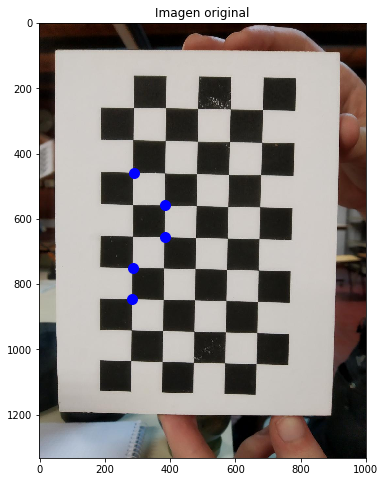

In [56]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Imagen original")
plt.imshow(d1);

for elem in [puntosDameroConRuido[i] for i in soporte]:
    marcar(plt, elem[0], elem[1])

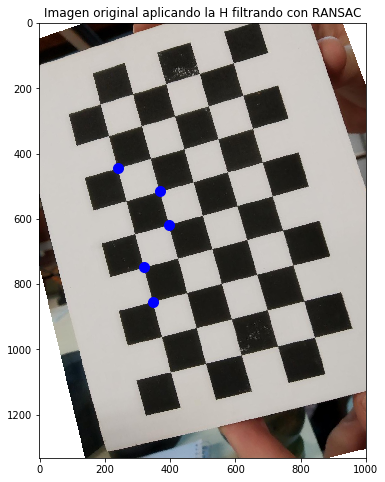

In [57]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Imagen original aplicando la H filtrando con RANSAC")
plt.imshow(dResultado.astype(np.uint8));

for elem in [puntosOtroDameroConRuido[i] for i in soporte]:
    marcar(plt, elem[0], elem[1])

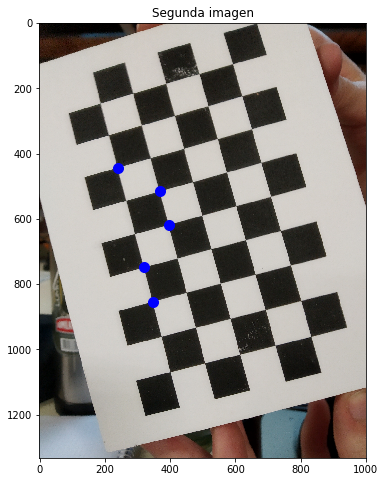

In [58]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Segunda imagen")
plt.imshow(d2.astype(np.uint8));

for elem in [puntosOtroDameroConRuido[i] for i in soporte]:
    marcar(plt, elem[0], elem[1])

### Conclusión

A pesar de no poder conseguir una homografía perfecta como cuando no considerábamos puntos ruidosos, gracias a RANSAC pudimos crear una imagen que se acerca a la deseada a partir de 50 correspondencias de las cuales el 30% es ruido completamente aleatorio.

Apreciamos además, que todas las correspondencias con las que se quedó RANSAC son correctas, por lo que concluimos que el algoritmo funciona correctamente para descartar correspondencias ruidosas. Notamos que el único motivo de error es que estas correspondencias, a pesar de ser correctas, no logran formar una homografía tan precisa como la que habría si no hubiera ruido.